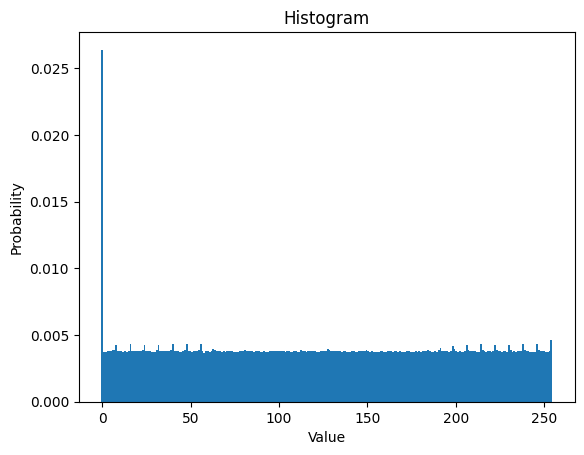

Entropy before processing: 7.815872249946615


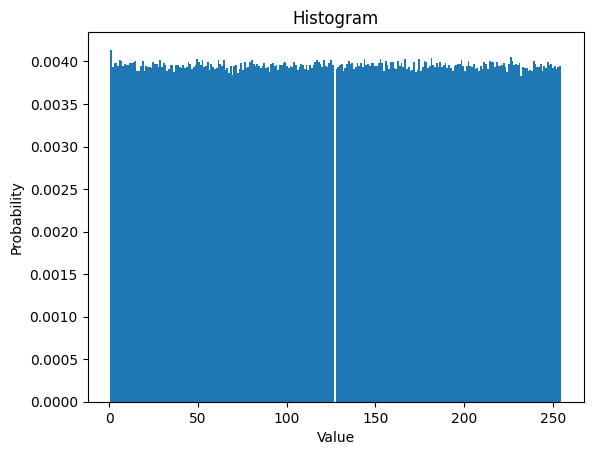

Entropy: 7.994279419719527
2805606


In [14]:
import wave
import matplotlib.pyplot as plt
import struct
import numpy as np

# Swap bits function 
def swap_bits(number):
    # Swap the 32 most significant bits with the 32 least significant bits
    msb = number >> 32 
    lsb = number & ((1 << 32) - 1)
    swapped_num = (lsb << 32) | msb

    #XOR operation
    result = swapped_num ^ number 
    return result

def entropy(labels, base=None): 
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    base = 2 if base is None else base
    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

def hist_input(A):
    r = []
    mask = 0b00000111
    for v in A:
        r.append(v & mask)
        
    r24 = []
    for i in range(0, len(r), 8):
        temp = r[i] << 21 | r[i+1] << 18 | r[i+2] << 15 | r[i+3] << 12 | r[i+4] << 9 | r[i+5] << 6 | r[i+6] << 3 | r[i+7]
        r24.append(temp)
        
    r_new = []
    for i in range(len(r24)):
        r_new.append(r24[i] & 0b111111110000000000000000 >> 16)
        r_new.append(r24[i] & 0b000000001111111100000000 >> 8)
        r_new.append(r24[i] & 0b000000000000000011111111)
        
    # Calculate the total number of occurrences
    total_occurrences = len(r_new)
    
    # Calculate the histogram with normalization
    hist, bins = np.histogram(r_new, bins=256, density=False)
    bin_widths = bins[1] - bins[0]
    hist = hist / total_occurrences
    
    # Plot the histogram
    plt.bar(bins[:-1], hist, width=bin_widths)

    # Title and labels
    plt.title("Histogram")
    plt.xlabel("Value")
    plt.ylabel("Probability")

    # Show the plot
    plt.show()
    
    return r

# Open the audio file and read the binary data
audio_file = wave.open('szur.wav', 'rb')
if audio_file is None:
    print('Error: Could not open audio file')
    exit()

nframes = audio_file.getnframes()

# Skip first 10000 frames
audio_file.setpos(10000)

# Read the audio data from the file
audio_data = audio_file.readframes(nframes)

# Convert the audio data to a numpy array
audio_data = np.frombuffer(audio_data, dtype=np.uint8)

audio_file.close()

# Set the parameters 
L = 8
N = 256000
gamma = 2 
epsilon = 0.1
alpha = 1
n = int(N / 256 * 8)
A = [] 

for bits in audio_data:
     A.append(bits)

if len(A) < N:
    raise ValueError("The audio file is too short")

# Create the histogram
hist_input(A)

# Calculate the entropy before processing
entropy_value = entropy(A, base = 2)
print('Entropy before processing:', entropy_value)

r = [] 
mask = 0b00000111
for v in A:
    r.append(v & mask)

x = [[0.141592, 0.653589, 0.793238, 0.462643, 0.383279, 0.502884, 0.197169, 0.399375]]
c = 0

# Define fT function
def fT(x, alpha):
    if 0 <= x < 0.5:
        return alpha * x
    elif 0.5 <= x <= 1:
        return alpha * (1 - x)
    else:
        raise ValueError("x must be in range of [0, 1]")

z = [0,0,0,0,0,0,0,0]
O = []
y = 0

while len(O) <= N:
    for i in range(L):
        t = len(x)-1
        x[t][i] = ((0.071428571 * r[y]) + x[t][i]) * 0.666666667
        c += 1
    for t in range(gamma):
        for i in range(L):
            try:
                x[t+1][i] = (1 - epsilon) * fT(x[t][i], alpha) + epsilon/2 * (fT(x[t][(i+1)%L], alpha)) + fT(x[t][(i-1)%L], alpha)
            except:
                x.append([0,0,0,0,0,0,0,0])
                x[t+1][i] = (1 - epsilon) * fT(x[t][i], alpha) + epsilon/2 * (fT(x[t][(i+1)%L], alpha)) + fT(x[t][(i-1)%L], alpha)
    for i in range(L):
        word = struct.pack('d', x[2][i])
        # Conversion to uint64
        int_value = int.from_bytes(word, byteorder='big', signed=False)
        z[i] = int_value
        x[0][i] = x[2][i]
    for i in range(int(L/2)):
        z[i] = int(z[i]) ^ swap_bits(int(z[i+int(L/2)]))
    O.append(z[0] + z[1]*256 + z[2]*pow(2,16) + z[3]*pow(2,24))
    y+=1

# Take 8 bits from the output
output = []
for j in range(len(O)-1):
    for i in range(0, 256, 8):
        byte = (O[j] >> (256 - (i + 8))) & 0xFF
        if (byte != 0):
            output.append(byte)

# Create the histogram with normalization
hist, bins = np.histogram(output, bins=256, density=True)

# Calculate bin widths
bin_widths = bins[1] - bins[0]

# Plot the histogram
plt.bar(bins[:-1], hist, width=bin_widths)

# Title and labels
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Probability')

# Show the plot
plt.show()

# Calculate the entropy
entropy_value = entropy(output, base = 2)
print('Entropy:', entropy_value)

# Save the output to a file
print(len(output))
with open('output3.txt', 'w') as file:
    file.write(str(output))

# Save the output to a binary file
with open('output3.bin', 'wb') as file:
    for byte in output:
        file.write(byte.to_bytes(1, byteorder='big'))